# Project 1 - Intelligent Machines

## Required to Run

In [24]:
# Install required packages (run once)
# !pip install xgboost lightgbm catboost optuna imbalanced-learn

## Imports and Configs

In [25]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve

# Advanced Models
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Imbalanced Learning
from imblearn.over_sampling import SMOTE, ADASYN

# Hyperparameter Tuning
import optuna
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings('ignore')

# Visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 1. Data Loading and Initial Exploration

- read_csv() - > فنكشن في pandas تخليك تقرا الاكسيل فايل و ال csv
- df.shape() - > يرجع لك عدد الصفوف والعمود
- df.head() - > يرجع لك اول 5 صفوف

In [26]:
# Load dataset
df = pd.read_csv('weatherAUS.csv')
print(f"Dataset shape: {df.shape}")
print(f"\n{'='*60}")
print("First few rows:")
df.head()

Dataset shape: (145460, 23)

First few rows:


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [27]:
# Check target distribution
print("Target Distribution:")
print(df['RainTomorrow'].value_counts())
print(f"\nImbalance Ratio: {df['RainTomorrow'].value_counts()['No'] / df['RainTomorrow'].value_counts()['Yes']:.2f}:1")

Target Distribution:
RainTomorrow
No     110316
Yes     31877
Name: count, dtype: int64

Imbalance Ratio: 3.46:1


## 2. Data Cleaning and Preprocessing

- dropna() - > يحذف القيم المفقودة
- subset=[] - > يحذف الصفوف التي تحتوي على القيم المفقودة في العمود المحدد
- to_datetime() - > يحول العمود إلى نوع datetime
- sort_values() - > يترتيب البيانات حسب العمود المحدد   
- reset_index() - > يعيد ترتيب الفهرس
- drop = True - > يحذف العمود المحدد

In [28]:
# Drop target nulls
df = df.dropna(subset=['RainTomorrow'])
print(f"Shape after dropping target nulls: {df.shape}")

# Keep Date for feature engineering, but convert it
df['Date'] = pd.to_datetime(df['Date'])

# Sort by location and date for lag features
df = df.sort_values(['Location', 'Date']).reset_index(drop=True)

print("✅ Data cleaned and sorted")

Shape after dropping target nulls: (142193, 23)
✅ Data cleaned and sorted


## 3. Advanced Feature Engineering
### Creating lag features, rolling windows, and cyclical date features

- ميزات التأخير (Lag Features)
الفكرة: هي ببساطة استخدام "الماضي" للتنبؤ بـ "المستقبل". في سياق الطقس، إذا أردت معرفة ما إذا كانت ستمطر غداً، فإن أهم معلومة هي: هل أمطرت اليوم؟ أو هل أمطرت أمس؟

- مثال:
- Lag 1: درجة الحرارة أمس.
- Lag 2: درجة الحرارة أول أمس.
- Lag 7: درجة الحرارة قبل أسبوع.
- لماذا نستخدمها؟ لأن الطقس لا يتغير فجأة بشكل عشوائي؛ هناك اعتماد كبير على الأيام السابقة.

- النوافذ المنزلقة (Rolling Windows)
الفكرة: بدلاً من النظر إلى يوم واحد محدد في الماضي (مثل أمس فقط)، ننظر إلى "ملخص" لفترة زمنية (نافذة) سابقة. هذا يساعد النموذج على فهم "الاتجاه العام" (Trend) بدلاً من التقلبات اليومية البسيطة.

- مثال (نافذة 7 أيام):
- Rolling Mean: متوسط درجة الحرارة في آخر 7 أيام.
- Rolling Max: أعلى درجة حرارة سجلت في آخر 7 أيام.
- لماذا نستخدمها؟ تساعد في تقليل الضجيج (Noise) في البيانات وتعطي النموذج فكرة عن الحالة العامة للجو مؤخراً (هل نحن في موجة حارّة؟ هل هناك منخفض جوي مستمر؟).

- ميزات التاريخ الدورية (Cyclical Date Features)
- الفكرة: الكمبيوتر لا يفهم أن "الوقت" عبارة عن دائرة. بالنسبة للكمبيوتر، شهر 12 (ديسمبر) وشهر 1 (يناير) بعيدان جداً عن بعضهما (الفرق بين الرقمين 12 و 1 هو 11). لكن في الواقع، هما متلاصقان في فصل الشتاء!
- لحل هذه المشكلة، نستخدم حساب المثلثات (Sin و Cos) لتحويل التواريخ إلى شكل دائري.

    - كيف تعمل؟
    - نقوم بتحويل الشهر (1-12) أو اليوم (1-365) إلى إحداثيات على دائرة.
    - بهذه الطريقة، يصبح شهر 12 قريباً جداً من شهر 1 رياضياً، مما يساعد النموذج على فهم "المواسم" بشكل صحيح.
    لماذا نستخدمها؟ لكي يفهم النموذج أن طقس بداية السنة يشبه طقس نهاية السنة (الشتاء)، ولا يعاملهما كأرقام متباعدة.

- ملخص سريع:

Lag: ماذا حدث أمس؟
Rolling: ماذا حدث في المتوسط خلال الأسبوع الماضي؟
Cyclical: أين نحن في فصول السنة (شتاء/صيف)؟


In [29]:
def create_advanced_features(data):
    """
    Create advanced features including:
    - Lag features (previous days)
    - Rolling window features
    - Cyclical date encoding
    - Interaction features
    - Location-specific climate features
    """
    df = data.copy()
    
    print("Creating advanced features...")
    
    # === 1. DATE FEATURES ===
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['Quarter'] = df['Date'].dt.quarter
    df['Season'] = df['Month'] % 12 // 3 + 1  # 1=Winter, 2=Spring, 3=Summer, 4=Fall
    
    # Cyclical encoding for month and day of year
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)
    
    # === 2. LAG FEATURES (Previous days) ===
    # Extended to 7 days as requested
    lag_features = ['Rainfall', 'Humidity3pm', 'Pressure3pm', 'Temp3pm', 'MinTemp', 'MaxTemp', 'WindSpeed3pm']
    
    for feature in lag_features:
        if feature in df.columns:
            for lag in range(1, 8):  # 1 to 7 days
                df[f'{feature}_lag{lag}'] = df.groupby('Location')[feature].shift(lag)
    
    # Lag for RainToday
    df['RainToday_encoded'] = df['RainToday'].map({'Yes': 1, 'No': 0})
    for lag in range(1, 4):
        df[f'RainToday_lag{lag}'] = df.groupby('Location')['RainToday_encoded'].shift(lag)
    
    # === 3. ROLLING WINDOW FEATURES ===
    rolling_features = ['Rainfall', 'Humidity3pm', 'Pressure3pm', 'Temp3pm']
    windows = [3, 7, 14] # Added 14 days
    
    for feature in rolling_features:
        if feature in df.columns:
            for window in windows:
                df[f'{feature}_rolling_{window}d_mean'] = df.groupby('Location')[feature].transform(
                    lambda x: x.rolling(window=window, min_periods=1).mean()
                )
                df[f'{feature}_rolling_{window}d_std'] = df.groupby('Location')[feature].transform(
                    lambda x: x.rolling(window=window, min_periods=1).std()
                )
    
    # === 4. LOCATION-SPECIFIC CLIMATE FEATURES (Expanding Mean) ===
    # Using expanding mean to avoid data leakage while capturing location "climate"
    climate_features = ['Rainfall', 'MaxTemp', 'MinTemp', 'Humidity3pm', 'WindGustSpeed']
    
    for feature in climate_features:
        if feature in df.columns:
            # Expanding mean gives the average up to that point in time for that location
            df[f'{feature}_Location_Mean'] = df.groupby('Location')[feature].transform(
                lambda x: x.expanding().mean()
            )
            # Deviation from the expanding mean (is today hotter/wetter than usual for this location?)
            df[f'{feature}_Location_Anomaly'] = df[feature] - df[f'{feature}_Location_Mean']
    
    # === 5. BASIC ENGINEERED FEATURES ===
    if 'MaxTemp' in df.columns and 'MinTemp' in df.columns:
        df['TempRange'] = df['MaxTemp'] - df['MinTemp']
        df['AvgTemp'] = (df['MaxTemp'] + df['MinTemp']) / 2
    
    if 'Pressure9am' in df.columns and 'Pressure3pm' in df.columns:
        df['PressureChange'] = df['Pressure3pm'] - df['Pressure9am']
    
    if 'Humidity9am' in df.columns and 'Humidity3pm' in df.columns:
        df['AvgHumidity'] = (df['Humidity9am'] + df['Humidity3pm']) / 2
        df['HumidityChange'] = df['Humidity3pm'] - df['Humidity9am']
    
    if 'Temp9am' in df.columns and 'Temp3pm' in df.columns:
        df['TempChange'] = df['Temp3pm'] - df['Temp9am']
    
    # === 6. INTERACTION FEATURES ===
    if 'Humidity3pm' in df.columns and 'Temp3pm' in df.columns:
        df['Humidity_Temp_interaction'] = df['Humidity3pm'] * df['Temp3pm']
    
    if 'PressureChange' in df.columns and 'WindSpeed3pm' in df.columns:
        df['Pressure_Wind_interaction'] = df['PressureChange'] * df['WindSpeed3pm']
    
    print(f"✅ Features created. New shape: {df.shape}")
    return df

# Apply feature engineering
df = create_advanced_features(df)
print(f"\nTotal features: {df.shape[1]}")

Creating advanced features...
✅ Features created. New shape: (142193, 127)

Total features: 127


- X - > دا اللي هتدرب عليه النموذج
- Y - > دا اللي هتتنبأ به النموذج

In [30]:
# Separate features and target
X = df.drop(['RainTomorrow', 'Date'], axis=1)
y = df['RainTomorrow'].map({'Yes': 1, 'No': 0})

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (142193, 125)
Target shape: (142193,)


## 4. Handle Missing Values and Encode Categoricals

- fillna() - > ملأ القيم المفقودة   
- Median() - > المتوسط عشان ديه ارقام
- Mode() - > المكرر عشان ديه كاتيجوري
- inplace=True - > يعدل القيم في الاصلي
- LabelEncoder() - > يحول الكاتيجوريز الي ارقام

In [31]:
# Identify column types
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols[:5]}...")
print(f"Numerical columns ({len(numerical_cols)}): {len(numerical_cols)} features")

# Fill missing values
for col in numerical_cols:
    X[col].fillna(X[col].median(), inplace=True)

for col in categorical_cols:
    X[col].fillna(X[col].mode()[0], inplace=True)

# Encode categoricals
le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

print("\n✅ Missing values handled and categoricals encoded")
print(f"Final feature count: {X.shape[1]}")

Categorical columns (5): ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']...
Numerical columns (115): 115 features

✅ Missing values handled and categoricals encoded
Final feature count: 125


## 5. Train-Test Split (BEFORE Balancing)

- train_test_split(train data, test data, test size , random state , stratify) - > لتقسيم البيانات في اصليه في بيانات تدريب و بيانات اختبار
- test size - > نسبة البيانات المستخدمة في الاختبار
- random state - > لجعل النتائج متساوية عند كل تشغيل
- stratify - > يتم استخدامه للتأكد من الحفاظ على نسب تسميات الفئة (أو المتغيرات التصنيفية الأخرى) في كل من مجموعات التدريب والاختبار بعد الانقسام.


In [32]:
# Split data - 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain class distribution:\n{y_train.value_counts()}")
print(f"\nTest class distribution:\n{y_test.value_counts()}")

Training set: (113754, 125)
Test set: (28439, 125)

Train class distribution:
RainTomorrow
0    88252
1    25502
Name: count, dtype: int64

Test class distribution:
RainTomorrow
0    22064
1     6375
Name: count, dtype: int64


## 6. Feature Scaling


- StandardScaler() - > يساعده على التماسك بالقيم الرقمية
- fit_transform() - > يحسب المتوسط والانحراف القياسي
- transform() - > يطبق التماسك على البيانات


In [33]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("✅ Features scaled")

✅ Features scaled


## 7. Handle Imbalanced Data with ADASYN

In [34]:
# Apply ADASYN (Adaptive Synthetic Sampling)
print("Class distribution BEFORE balancing:")
print(y_train.value_counts())

adasyn = ADASYN(random_state=42, n_neighbors=5)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train_scaled, y_train)

print("\nClass distribution AFTER ADASYN:")
print(pd.Series(y_train_balanced).value_counts())
print(f"\n✅ Balanced training data shape: {X_train_balanced.shape}")

Class distribution BEFORE balancing:
RainTomorrow
0    88252
1    25502
Name: count, dtype: int64

Class distribution AFTER ADASYN:
RainTomorrow
0    88252
1    87416
Name: count, dtype: int64

✅ Balanced training data shape: (175668, 125)


## 8. Advanced Models with Optuna Hyperparameter Tuning
### We'll optimize XGBoost, LightGBM, and CatBoost

- model.fit(train data, train labels) - > التدريب على البيانات
- model.predict(test data) - > التوقعات على البيانات


In [35]:
# Define evaluation function
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """
    Train model and evaluate on test set
    """
    print(f"\n{'='*70}")
    print(f"Training {name}...")
    print(f"{'='*70}")
    
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\n📊 Results:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   ROC-AUC: {auc:.4f}")
    
    print(f"\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['No Rain', 'Rain']))
    
    return {
        'model': model,
        'accuracy': accuracy,
        'f1': f1,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

### 8.1 XGBoost with Optuna

In [36]:
def optimize_xgboost(trial):
    """
    Optuna objective function for XGBoost
    """
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    }
    
    model = xgb.XGBClassifier(**params)
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=cv, scoring='f1')
    
    return scores.mean()

# Run optimization
print("🔍 Optimizing XGBoost with Optuna (this may take a few minutes)...\n")
study_xgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_xgb.optimize(optimize_xgboost, n_trials=30, show_progress_bar=True)

print(f"\n✅ Best F1-Score (CV): {study_xgb.best_value:.4f}")
print(f"\n📊 Best Parameters:")
for key, value in study_xgb.best_params.items():
    print(f"   {key}: {value}")

# Train final model with best params
best_xgb_params = study_xgb.best_params
best_xgb_params.update({'random_state': 42, 'eval_metric': 'logloss', 'use_label_encoder': False})
xgb_model = xgb.XGBClassifier(**best_xgb_params)

xgb_results = evaluate_model('XGBoost (Optimized)', xgb_model, X_train_balanced, y_train_balanced, X_test_scaled, y_test)

[I 2025-11-28 18:30:55,121] A new study created in memory with name: no-name-9ee27441-40c9-454e-93ef-a8e213d815f2


🔍 Optimizing XGBoost with Optuna (this may take a few minutes)...



  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-28 18:31:41,589] Trial 0 finished with value: 0.905351263350945 and parameters: {'max_depth': 5, 'learning_rate': 0.28570714885887566, 'n_estimators': 393, 'min_child_weight': 5, 'gamma': 0.07800932022121826, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088}. Best is trial 0 with value: 0.905351263350945.
[I 2025-11-28 18:33:31,535] Trial 1 finished with value: 0.9008597861964954 and parameters: {'max_depth': 8, 'learning_rate': 0.01596950334578271, 'n_estimators': 488, 'min_child_weight': 6, 'gamma': 0.10616955533913808, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 0 with value: 0.905351263350945.
[I 2025-11-28 18:34:22,080] Trial 2 finished with value: 0.9084562486331857 and parameters: {'max_depth': 6, 'learning_rate': 0.09445645065743215, 'n_estimators': 345, 'min_child_weigh

### 8.2 LightGBM with Optuna

In [37]:
def optimize_lightgbm(trial):
    """
    Optuna objective function for LightGBM
    """
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
        'verbosity': -1
    }
    
    model = lgb.LGBMClassifier(**params)
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=cv, scoring='f1')
    
    return scores.mean()

# Run optimization
print("🔍 Optimizing LightGBM with Optuna (this may take a few minutes)...\n")
study_lgb = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study_lgb.optimize(optimize_lightgbm, n_trials=30, show_progress_bar=True)

print(f"\n✅ Best F1-Score (CV): {study_lgb.best_value:.4f}")
print(f"\n📊 Best Parameters:")
for key, value in study_lgb.best_params.items():
    print(f"   {key}: {value}")

# Train final model with best params
best_lgb_params = study_lgb.best_params
best_lgb_params.update({'random_state': 42, 'verbosity': -1})
lgb_model = lgb.LGBMClassifier(**best_lgb_params)

lgb_results = evaluate_model('LightGBM (Optimized)', lgb_model, X_train_balanced, y_train_balanced, X_test_scaled, y_test)

[I 2025-11-28 18:58:56,279] A new study created in memory with name: no-name-eec36aa9-e2f7-4e14-b760-a855cc3975b2


🔍 Optimizing LightGBM with Optuna (this may take a few minutes)...



  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-28 18:59:23,252] Trial 0 finished with value: 0.9071196294938648 and parameters: {'max_depth': 5, 'learning_rate': 0.28570714885887566, 'n_estimators': 393, 'num_leaves': 68, 'min_child_samples': 16, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.8661761457749352, 'reg_lambda': 0.6011150117432088}. Best is trial 0 with value: 0.9071196294938648.
[I 2025-11-28 19:00:34,264] Trial 1 finished with value: 0.901694440351733 and parameters: {'max_depth': 8, 'learning_rate': 0.01596950334578271, 'n_estimators': 488, 'num_leaves': 87, 'min_child_samples': 18, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 0.3042422429595377, 'reg_lambda': 0.5247564316322378}. Best is trial 0 with value: 0.9071196294938648.
[I 2025-11-28 19:01:05,733] Trial 2 finished with value: 0.9075534009622315 and parameters: {'max_depth': 6, 'learning_rate': 0.09445645065743215, 'n_estimators': 345, 'num_leaves': 31, 'min_child_sampl

### 8.3 CatBoost (Self-Tuning)

In [38]:
# CatBoost with good default parameters
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_seed=42,
    verbose=False
)

catboost_results = evaluate_model('CatBoost', catboost_model, X_train_balanced, y_train_balanced, X_test_scaled, y_test)


Training CatBoost...

📊 Results:
   Accuracy: 0.8622
   F1-Score: 0.6512
   ROC-AUC: 0.8974

📋 Classification Report:
              precision    recall  f1-score   support

     No Rain       0.88      0.95      0.91     22064
        Rain       0.75      0.57      0.65      6375

    accuracy                           0.86     28439
   macro avg       0.82      0.76      0.78     28439
weighted avg       0.86      0.86      0.86     28439



### 8.4 Random Forest (Baseline)

In [39]:
# Random Forest for comparison
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_results = evaluate_model('Random Forest', rf_model, X_train_balanced, y_train_balanced, X_test_scaled, y_test)


Training Random Forest...

📊 Results:
   Accuracy: 0.8301
   F1-Score: 0.6606
   ROC-AUC: 0.8908

📋 Classification Report:
              precision    recall  f1-score   support

     No Rain       0.92      0.86      0.89     22064
        Rain       0.60      0.74      0.66      6375

    accuracy                           0.83     28439
   macro avg       0.76      0.80      0.77     28439
weighted avg       0.85      0.83      0.84     28439



## 9. Advanced Stacking Ensemble

In [40]:
# Create stacking ensemble with best models
print("\n" + "="*70)
print("🎭 Creating Advanced Stacking Ensemble")
print("="*70)

estimators = [
    ('xgb', xgb_results['model']),
    ('lgb', lgb_results['model']),
    ('catboost', catboost_results['model']),
    ('rf', rf_results['model'])
]

# Use Logistic Regression as meta-learner
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=42, max_iter=1000),
    cv=3
)

stacking_results = evaluate_model('Stacking Ensemble', stacking_model, X_train_balanced, y_train_balanced, X_test_scaled, y_test)


🎭 Creating Advanced Stacking Ensemble

Training Stacking Ensemble...

📊 Results:
   Accuracy: 0.8640
   F1-Score: 0.7046
   ROC-AUC: 0.9050

📋 Classification Report:
              precision    recall  f1-score   support

     No Rain       0.92      0.90      0.91     22064
        Rain       0.69      0.72      0.70      6375

    accuracy                           0.86     28439
   macro avg       0.80      0.81      0.81     28439
weighted avg       0.87      0.86      0.87     28439



## 10. Threshold Optimization for F1-Score

In [41]:
def optimize_threshold(y_true, y_proba):
    """
    Find optimal classification threshold for F1-score
    """
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold, best_f1

# Optimize threshold for best model (Stacking)
best_threshold, optimized_f1 = optimize_threshold(y_test, stacking_results['probabilities'])

print(f"\n🎯 Threshold Optimization Results:")
print(f"   Best Threshold: {best_threshold:.3f}")
print(f"   Optimized F1-Score: {optimized_f1:.4f}")
print(f"   Original F1-Score: {stacking_results['f1']:.4f}")
print(f"   Improvement: {(optimized_f1 - stacking_results['f1']):.4f}")

# Apply optimized threshold
y_pred_optimized = (stacking_results['probabilities'] >= best_threshold).astype(int)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)

print(f"\n📊 Final Results with Optimized Threshold:")
print(f"   Accuracy: {accuracy_optimized:.4f}")
print(f"   F1-Score: {optimized_f1:.4f}")
print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred_optimized, target_names=['No Rain', 'Rain']))


🎯 Threshold Optimization Results:
   Best Threshold: 0.500
   Optimized F1-Score: 0.7046
   Original F1-Score: 0.7046
   Improvement: 0.0000

📊 Final Results with Optimized Threshold:
   Accuracy: 0.8640
   F1-Score: 0.7046

📋 Classification Report:
              precision    recall  f1-score   support

     No Rain       0.92      0.90      0.91     22064
        Rain       0.69      0.72      0.70      6375

    accuracy                           0.86     28439
   macro avg       0.80      0.81      0.81     28439
weighted avg       0.87      0.86      0.87     28439



## 11. Final Model Comparison

In [42]:
# Compile all results
results_summary = pd.DataFrame([
    {'Model': 'XGBoost', 'Accuracy': xgb_results['accuracy'], 'F1-Score': xgb_results['f1'], 'ROC-AUC': xgb_results['auc']},
    {'Model': 'LightGBM', 'Accuracy': lgb_results['accuracy'], 'F1-Score': lgb_results['f1'], 'ROC-AUC': lgb_results['auc']},
    {'Model': 'CatBoost', 'Accuracy': catboost_results['accuracy'], 'F1-Score': catboost_results['f1'], 'ROC-AUC': catboost_results['auc']},
    {'Model': 'Random Forest', 'Accuracy': rf_results['accuracy'], 'F1-Score': rf_results['f1'], 'ROC-AUC': rf_results['auc']},
    {'Model': 'Stacking', 'Accuracy': stacking_results['accuracy'], 'F1-Score': stacking_results['f1'], 'ROC-AUC': stacking_results['auc']},
    {'Model': 'Stacking (Optimized)', 'Accuracy': accuracy_optimized, 'F1-Score': optimized_f1, 'ROC-AUC': stacking_results['auc']}
]).sort_values('Accuracy', ascending=False)

print("\n" + "="*80)
print("🏆 FINAL MODEL COMPARISON")
print("="*80)
print(results_summary.to_string(index=False))

# Highlight best model
best_model = results_summary.iloc[0]
print(f"\n\n🎉 BEST MODEL: {best_model['Model']}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   F1-Score: {best_model['F1-Score']:.4f}")
print(f"   ROC-AUC: {best_model['ROC-AUC']:.4f}")

if best_model['Accuracy'] >= 0.90:
    print("\n🎯 🎯 🎯 TARGET ACHIEVED: 90%+ ACCURACY! 🎯 🎯 🎯")
else:
    print(f"\n📈 Gap to 90%: {(0.90 - best_model['Accuracy']):.4f} ({(0.90 - best_model['Accuracy'])*100:.2f}%)")


🏆 FINAL MODEL COMPARISON
               Model  Accuracy  F1-Score  ROC-AUC
             XGBoost  0.872288  0.684558 0.908813
            LightGBM  0.870776  0.679962 0.909670
Stacking (Optimized)  0.863990  0.704552 0.904992
            Stacking  0.863990  0.704552 0.904992
            CatBoost  0.862196  0.651241 0.897398
       Random Forest  0.830057  0.660580 0.890829


🎉 BEST MODEL: XGBoost
   Accuracy: 0.8723
   F1-Score: 0.6846
   ROC-AUC: 0.9088

📈 Gap to 90%: 0.0277 (2.77%)


## 12. Visualizations

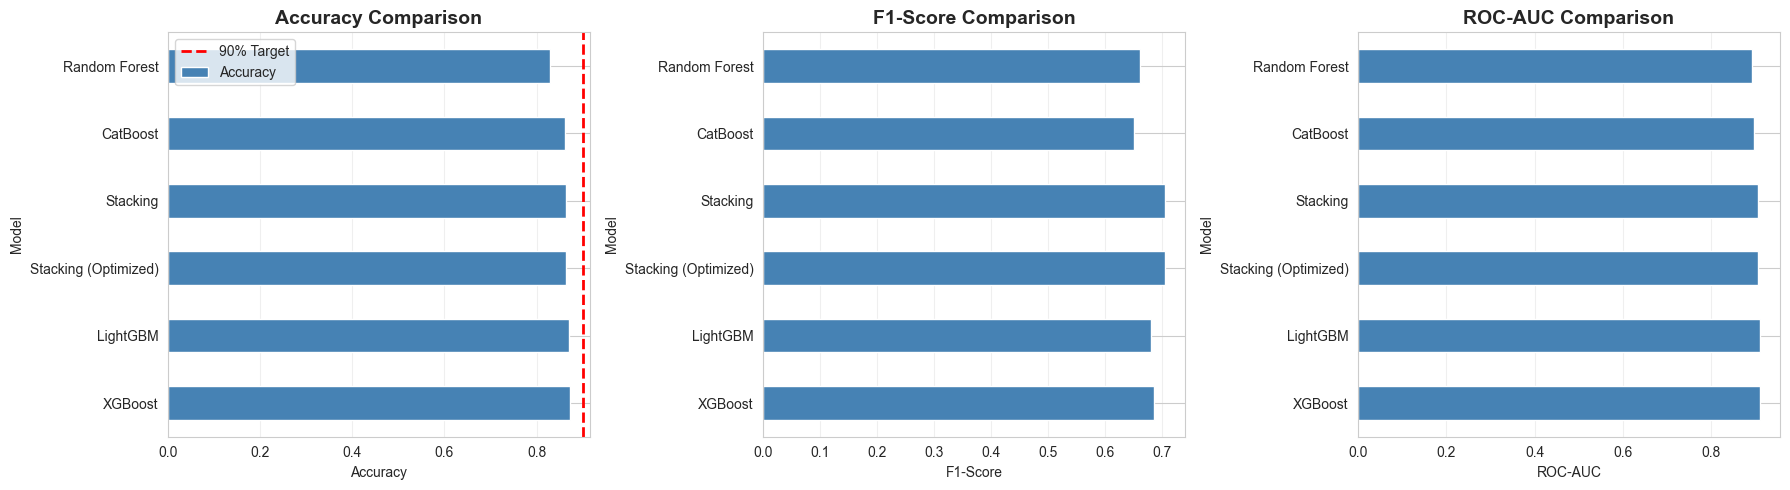

In [43]:
# Model comparison bar chart
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Accuracy', 'F1-Score', 'ROC-AUC']
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    results_summary.plot(x='Model', y=metric, kind='barh', ax=ax, legend=False, color='steelblue')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xlabel(metric)
    ax.set_ylabel('Model')
    ax.grid(axis='x', alpha=0.3)
    
    # Add 90% line for accuracy
    if metric == 'Accuracy':
        ax.axvline(x=0.90, color='red', linestyle='--', linewidth=2, label='90% Target')
        ax.legend()

plt.tight_layout()
plt.show()

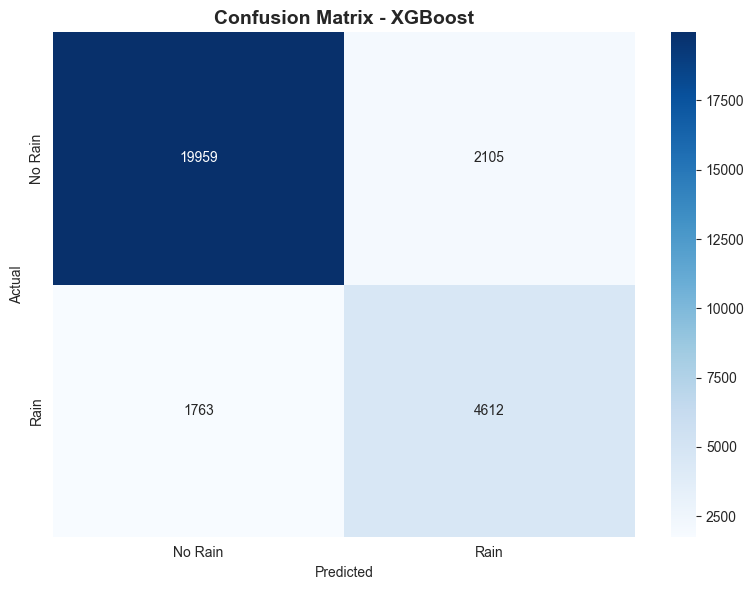

In [44]:
# Confusion Matrix for best model
cm = confusion_matrix(y_test, y_pred_optimized)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Rain', 'Rain'],
            yticklabels=['No Rain', 'Rain'])
plt.title(f'Confusion Matrix - {best_model["Model"]}', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

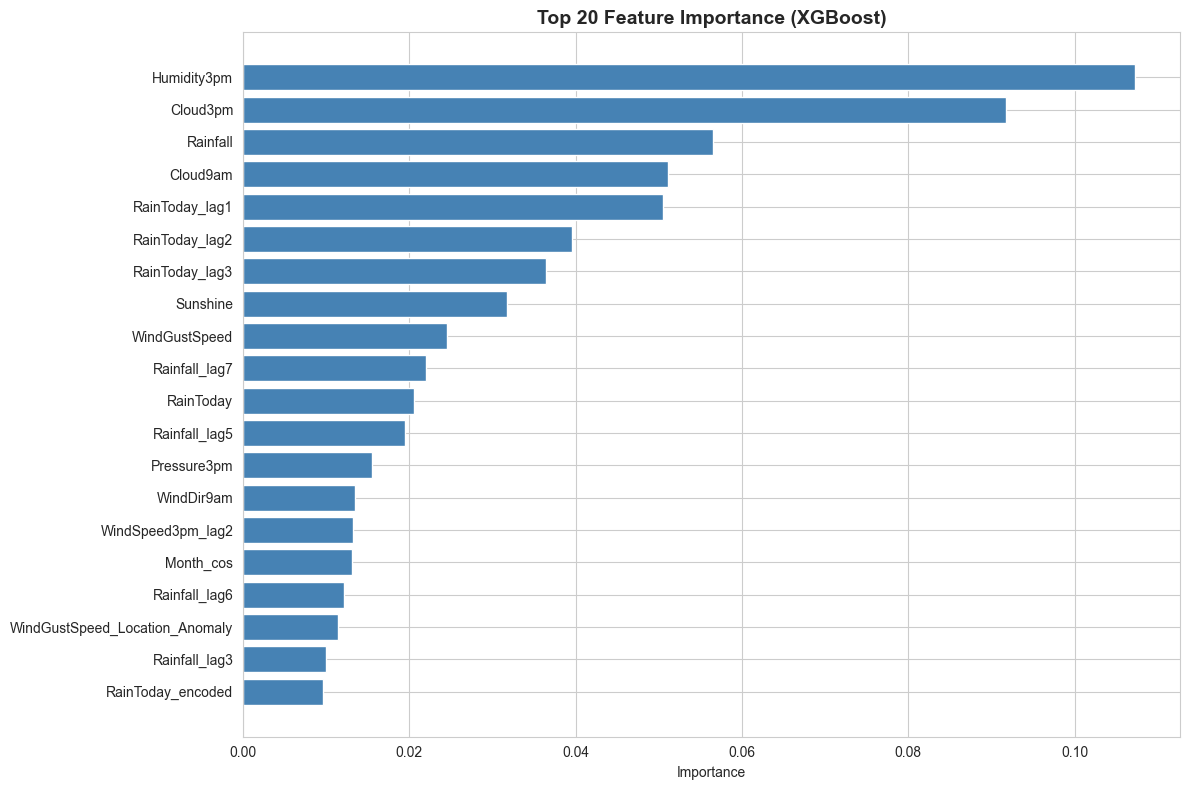


Top 10 Most Important Features:
       Feature  Importance
   Humidity3pm    0.107319
      Cloud3pm    0.091763
      Rainfall    0.056531
      Cloud9am    0.051060
RainToday_lag1    0.050496
RainToday_lag2    0.039514
RainToday_lag3    0.036427
      Sunshine    0.031810
 WindGustSpeed    0.024514
 Rainfall_lag7    0.022038


In [45]:
# Feature importance from XGBoost
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_results['model'].feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))